In [4]:
!pip install tensorflow_ranking prettytable

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, ConvLSTM1D, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, SpatialDropout1D, Dropout, TimeDistributed

from keras.regularizers import l2, l1


from sklearn.decomposition import PCA
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn

import pickle

from featurize import featurize_acc_gyr

from scaler import CustomScaler

2023-04-13 10:57:18.862642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 10:57:19.867685: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-13 10:57:19.867785: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-13 10:57:19.867795: W tensorfl

In [6]:
file_name = "raw_with_maps"

x_data = np.load(f"data/processed/x_{file_name}_filtered.npy")[:,:,[0,1,2,4,5,6]] # pre-filtered data is "windowed_filtered"
feature_x_data = np.load(f"data/processed/x_{file_name}_features_acc_gyr.npy")
y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy")
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy")
test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy")

In [7]:
#new_features = featurize_acc_gyr(np.load(f"data/processed/x_{file_name}_filtered.npy")[:,:,:8], filter_indices = [0,1,2,4,5,6])

In [8]:
#np.save(f"data/processed/x_{file_name}_features_acc_gyr.npy", new_features)

## RF approach

In [9]:
def get_eer(scores_legit, scores_adv):
    scores_legit = sorted(scores_legit)
    scores_adv = sorted(scores_adv)

    unique_scores_legit = sorted(set(scores_legit))
    
    #treat each legitimate sample distance as a possible threshold, determine the point where FRR crosses FAR
    for c, threshold in enumerate(unique_scores_legit):
        frr = sum(1 if x < threshold else 0 for x in scores_legit) / len(scores_legit)
        far = sum(1 if x >= threshold else 0 for x in scores_adv) / len(scores_adv)
        if frr >= far:
            return threshold, far, frr
    print("Failure")

def get_far_when_zero_frr(scores_legit, scores_adv):
    scores_legit = sorted(scores_legit)
    scores_adv = sorted(scores_adv)

    unique_scores_legit = sorted(set(scores_legit))
    
    last_far = 1.0
    last_frr = 0.0
    last_threshold = 0.0
    
    #treat each legitimate sample distance as a possible threshold, determine the point with the lowest FAR that satisfies the condition that FRR = 0
    for c, threshold in enumerate(unique_scores_legit):
        frr = sum(1 if x < threshold else 0 for x in scores_legit) / len(scores_legit)
        far = sum(1 if x >= threshold else 0 for x in scores_adv) / len(scores_adv)
        if frr > 0.001:
            return last_threshold, last_far, last_frr
        last_far = far
        last_frr = frr
        last_threshold = threshold

scores_legit = [i / 100 for i in range(30,101)]
scores_adv = [i / 100 for i in range(5, 85)]
display(get_eer(scores_legit, scores_adv))
display(get_far_when_zero_frr(scores_legit, scores_adv))

(0.56, 0.3625, 0.36619718309859156)

(0.3, 0.6875, 0.0)

In [71]:
def show_evaluate_model(labels_test, labels_pred, labels_scores, verbose = 1):
    

    fmeasure = f1_score(labels_test, labels_pred, average = "binary", labels = np.unique(labels_pred)) 
    auroc = sklearn.metrics.roc_auc_score(labels_test, labels_scores, labels = np.unique(labels_pred))

    scores_legit = [labels_scores[i] for i in range(len(labels_test)) if 1 == labels_test[i]]
    scores_adv = [labels_scores[i] for i in range(len(labels_test)) if 0 == labels_test[i]]

    eer_theta, eer, frr_at_eer = get_eer(scores_legit, scores_adv)
    far_theta, far, frr_at_zero_frr = get_far_when_zero_frr(scores_legit, scores_adv)
    
    if verbose:
        plt.hist(labels_scores, bins=100)
        plt.show()
        print(f"F1 score        : {fmeasure}")
        print(f"AUROC           : {auroc}")
        print(f"EER             : {eer}")
        print(f"frr_at_eer      : {frr_at_eer}")
        print(f"far at zero frr : {far}")
        print(f"frr at 'zero' frr : {frr_at_zero_frr}")

    accuracy = sum(labels_test == labels_pred) / len(labels_test)
    
    return {"fmeasure":fmeasure, "auroc":auroc, "eer_theta":eer_theta, "eer":eer, "frr_at_eer":frr_at_eer, 
            "far_theta":far_theta, "far":far, "frr_at_zero_frr":frr_at_zero_frr, "accuracy":accuracy}

In [29]:
auth_user = 0

_map = (train_gesture_map == 1)
_test_map = (test_gesture_map == 1)

data_train = x_data[_map]
feature_data_train = feature_x_data[_map]
labels_train = (y_user.argmax(axis=1) == auth_user)[_map].astype(int) #

"""
shuffled_data_train, shuffled_labels_train = shuffle(data_train, labels_train, random_state=0)

scaler = CustomScaler()
scaler.CHANNELS = 6
shuffled_data_train = scaler.fit_and_transform(shuffled_data_train)

np.unique(shuffled_labels_train, return_counts=True)
"""

'\nshuffled_data_train, shuffled_labels_train = shuffle(data_train, labels_train, random_state=0)\n\nscaler = CustomScaler()\nscaler.CHANNELS = 6\nshuffled_data_train = scaler.fit_and_transform(shuffled_data_train)\n\nnp.unique(shuffled_labels_train, return_counts=True)\n'

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

shuffled_data_train, shuffled_labels_train = shuffle(feature_data_train, labels_train, random_state=0)

standard_scaler = StandardScaler()
shuffled_data_train = standard_scaler.fit_transform(shuffled_data_train)

#kFold = sklearn.model_selection.StratifiedKFold(n_splits=5)
#val_map = next(kFold.split(shuffled_data_train, shuffled_labels_train))[1]

wa_model = RandomForestClassifier(n_estimators = 700, random_state = 0, class_weight={0:1,1:1}).fit(shuffled_data_train, shuffled_labels_train)





In [41]:
count = 0
for tree_in_forest in wa_model.estimators_:
    count += tree_in_forest.tree_.node_count
print(count)

81692


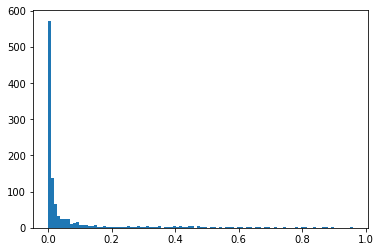

F1 score        : 0.7693719806763285
AUROC           : 0.9663396792360431
EER             : 0.08129285014691479
frr_at_eer      : 0.109375
far at zero frr : 0.41625857002938293
frr at 'zero' frr : 0.0


{'fmeasure': 0.7693719806763285,
 'auroc': 0.9663396792360431,
 'eer_theta': 0.13285714285714287,
 'eer': 0.08129285014691479,
 'frr_at_eer': 0.109375,
 'far_theta': 0.011428571428571429,
 'far': 0.41625857002938293,
 'frr_at_zero_frr': 0.0,
 'accuracy': 0.9594470046082949}

In [42]:
labels_pred = wa_model.predict(standard_scaler.transform(feature_x_data[_test_map]))
labels_scores = wa_model.predict_proba(standard_scaler.transform(feature_x_data[_test_map]))[:, 1]

labels_test = (y_user.argmax(axis=1) == auth_user)[_test_map].astype(int)

#stat_dict = {"labels_pred": labels_pred, "labels_scores":labels_scores, "labels_test":labels_test}
#with open(f'data/stats/auth/RF_user={auth_user}.pickle', 'wb') as f:
#    pickle.dump(stat_dict, f)

show_evaluate_model(labels_test, labels_pred, labels_scores)

In [8]:
class SplitLayer(tf.keras.layers.Layer):
    def __init__(self, layers):
        super(SplitLayer, self).__init__()
        self.layers = layers

    def call(self, inputs):
        return tf.gather(inputs,indices=self.layers,axis=-1)

def get_mlp_model(input_dim=(200,6), outputs=1):
    inputs = keras.Input(shape=input_dim)
    x = inputs
    
    x = Flatten()(x)
    x = Dense(50, activation="relu")(x)
    x = Dense(50, activation="relu")(x)
    x = Dense(50, activation="relu")(x)
    x = Dense(50, activation="relu")(x)
    x = Dense(50, activation="relu")(x)
    x = Dense(50, activation="relu")(x)
    #x = Dropout(0.1)(x)
    if outputs == 1:
        x = Dense(1, activation="sigmoid")(x)
    else:
        x = Dense(outputs, activation="softmax")(x)
    
    out = x
    
    model = keras.Model(inputs, out, name="MLP_classifier")
    
    return model
    
def get_gru_model(input_dim=(200,6)):
    inputs = keras.Input(shape=input_dim)
    x = inputs
    
    x = layers.GRU(68, return_sequences=True)(x)
    x = layers.GRU(68, return_sequences=True)(x)
    x = layers.GRU(68)(x)
    
    x = Dense(25, activation="relu")(x)
    x = Dense(10, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x
    model = keras.Model(inputs, x, name="GRU_classifier")
    return model

def get_conv_model():
    # requires input dim with 6 channels for dimensions
    input_dim = (200,6)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs
    
    xs = []
    last_output_channels = 23
    for a in range(8):
        x = Conv1D(last_output_channels * 6, 3, strides=1, groups=input_dim[1], padding="same", activation="relu")(x)
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
    
    x = Flatten()(x)

    x = Dense(25, activation="relu")(x)
    x = Dense(10, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x

    model = keras.Model(inputs, out, name="simple_conv_classifier")
    
    return model

def get_simple_mix_model():
    # requires input dim with 6 channels for dimensions
    input_dim = (200,6)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs
    
    xs = []
    last_output_channels = 23
    for a in range(5):
        x = Conv1D(last_output_channels * 6, 3, strides=1, groups=input_dim[1], padding="same", activation="relu")(x)
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
    
    x = layers.GRU(32, return_sequences=True)(x)
    x = layers.GRU(32, return_sequences=True)(x)
    x = layers.GRU(32)(x)

    x = Dense(25, activation="relu")(x)
    x = Dense(10, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x

    model = keras.Model(inputs, out, name="simple_conv_gru_classifier")
    
    return model

def get_complex_mix_model():

    input_dim = (200,6)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs
    y = inputs
    
    
    
    last_output_channels = 22
    for a in range(4):
        x0 = Conv1D(last_output_channels, 1, strides=1, padding="same", activation="relu")(x)
        x1 = Conv1D(last_output_channels, 3, strides=1, padding="same", activation="relu")(x)
        x2 = Conv1D(last_output_channels, 5, strides=1, padding="same", activation="relu")(x)
        x3 = Conv1D(last_output_channels, 10, strides=1, padding="same", activation="relu")(x)
        x0 = MaxPooling1D(pool_size=2, strides=None, padding="same")(x0)
        x1 = MaxPooling1D(pool_size=2, strides=None, padding="same")(x1)
        x2 = MaxPooling1D(pool_size=2, strides=None, padding="same")(x2)
        x3 = MaxPooling1D(pool_size=2, strides=None, padding="same")(x3)
        x = layers.Concatenate()([x0,x1,x2,x3])
        
        x = layers.TimeDistributed(Dense(30, activation="relu"))(x) # , kernel_regularizer=keras.regularizers.L1(1e-4)))(x) # 
        
        
    x = layers.GRU(32, return_sequences=True)(x)
    x = layers.GRU(32, return_sequences=True)(x)
    x = layers.GRU(32)(x)

    x = Dense(25, activation="relu")(x)
    x = Dense(10, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x

    model = keras.Model(inputs, out, name="complex_conv_GRU_classifier")
    
    return model


get_mlp_model().summary()
get_gru_model().summary()
get_conv_model().summary()
get_simple_mix_model().summary()
get_complex_mix_model().summary()

Model: "MLP_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 6)]          0         
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 50)                60050     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 50)             

2023-03-10 16:22:24.805185: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-10 16:22:24.806726: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


Model: "GRU_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 6)]          0         
                                                                 
 gru (GRU)                   (None, 200, 68)           15504     
                                                                 
 gru_1 (GRU)                 (None, 200, 68)           28152     
                                                                 
 gru_2 (GRU)                 (None, 68)                28152     
                                                                 
 dense_7 (Dense)             (None, 25)                1725      
                                                                 
 dense_8 (Dense)             (None, 10)                260       
                                                                 
 dense_9 (Dense)             (None, 1)              

In [10]:
shuffled_data_train, shuffled_labels_train = shuffle(data_train, labels_train, random_state=0)

scaler = CustomScaler()
scaler.CHANNELS = 6
shuffled_data_train = scaler.fit_and_transform(shuffled_data_train)

np.unique(shuffled_labels_train, return_counts=True)

(array([0, 1]), array([2254,  145]))

In [15]:
#model = get_mlp_model()
#model = get_gru_model()
#model = get_conv_model()
#model = get_simple_mix_model()
model = get_complex_mix_model()
model.summary()

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))



kFold = sklearn.model_selection.StratifiedKFold(n_splits=5)
val_map = next(kFold.split(shuffled_data_train, shuffled_labels_train))[1]


val_map_all = np.zeros(len(shuffled_labels_train))
val_map_all[val_map] = 1

val_map = val_map_all == 1

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=100,
                                                           patience=150, restore_best_weights=True)

print(np.unique(shuffled_labels_train[val_map], return_counts=True))
print(np.unique(shuffled_labels_train[~val_map], return_counts=True))


history = model.fit(shuffled_data_train[~val_map], shuffled_labels_train[~val_map], epochs=3000,
                        batch_size=1024, verbose=1,
                        validation_data=(shuffled_data_train[val_map], shuffled_labels_train[val_map]),
                       class_weight={0:1, 1:15*4}, 
                   callbacks=[early_stopping_callback])
                       #)


#with open(f'data/models/DL/ConvLSTM_user={auth_user}.pickle', 'wb') as f:
#    pickle.dump(model, f)#

#with open(f'data/stats/auth/ConvLSTM_user={auth_user}_history.pickle', 'wb') as f:
#    pickle.dump(history, f)
    
"""
with tf.keras.utils.custom_object_scope({"SplitLayer":SplitLayer}):
    with open(f'data/models/DL/ConvLSTM_user={auth_user}.pickle', 'rb') as pickle_file:
        self.encoder = pickle.load(pickle_file)
"""



"""
for i in range(10):
    

    history = model.fit(shuffled_data_train[~val_map], shuffled_labels_train[~val_map], epochs=100,
                        batch_size=1024, verbose=1,
                        validation_data=(shuffled_data_train[val_map], shuffled_labels_train[val_map]),
                       class_weight={0:1, 1:60}, )
                       #callbacks=[early_stopping_callback])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.clf()
    
    labels_scores = model.predict(scaler.transform(x_data[_test_map])).squeeze()

    #labels_scores = model.predict(shuffled_data_train[~val_map]).squeeze()
    labels_pred = (labels_scores >= 0.5).astype(int)

    labels_test = (y_user.argmax(axis=1) == auth_user)[_test_map].astype(int)

    show_evaluate_model(labels_test, labels_pred, labels_scores)
"""


Model: "complex_conv_GRU_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 200, 6)]     0           []                               
                                                                                                  
 conv1d_34 (Conv1D)             (None, 200, 22)      154         ['input_7[0][0]']                
                                                                                                  
 conv1d_35 (Conv1D)             (None, 200, 22)      418         ['input_7[0][0]']                
                                                                                                  
 conv1d_36 (Conv1D)             (None, 200, 22)      682         ['input_7[0][0]']                
                                                                        

"\nfor i in range(10):\n    \n\n    history = model.fit(shuffled_data_train[~val_map], shuffled_labels_train[~val_map], epochs=100,\n                        batch_size=1024, verbose=1,\n                        validation_data=(shuffled_data_train[val_map], shuffled_labels_train[val_map]),\n                       class_weight={0:1, 1:60}, )\n                       #callbacks=[early_stopping_callback])\n\n    plt.plot(history.history['loss'])\n    plt.plot(history.history['val_loss'])\n    plt.title('model loss')\n    plt.ylabel('loss')\n    plt.xlabel('epoch')\n    plt.legend(['train', 'val'], loc='upper left')\n    plt.show()\n\n    plt.clf()\n    \n    labels_scores = model.predict(scaler.transform(x_data[_test_map])).squeeze()\n\n    #labels_scores = model.predict(shuffled_data_train[~val_map]).squeeze()\n    labels_pred = (labels_scores >= 0.5).astype(int)\n\n    labels_test = (y_user.argmax(axis=1) == auth_user)[_test_map].astype(int)\n\n    show_evaluate_model(labels_test, labels_

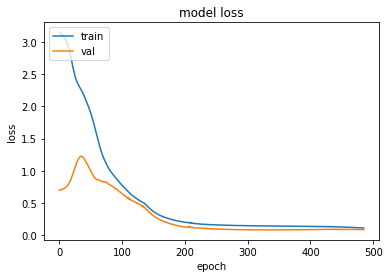

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.clf()

34/34 [==============================] - 0s 7ms/step


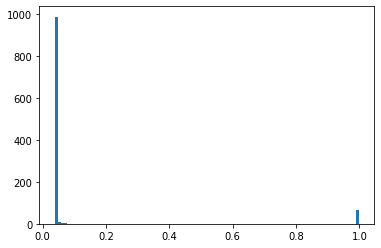

F1 score        : 0.8823529411764706
AUROC           : 0.9952558765915769
EER             : 0.01665034280117532
frr_at_eer      : 0.03125
far at zero frr : 0.04603330068560235
frr at 'zero' frr : 0.0


{'fmeasure': 0.8823529411764706,
 'auroc': 0.9952558765915769,
 'eer_theta': 0.07608458,
 'eer': 0.01665034280117532,
 'frr_at_eer': 0.03125,
 'far_theta': 0.043404665,
 'far': 0.04603330068560235,
 'frr_at_zero_frr': 0.0,
 'accuracy': 0.9852534562211982}

In [19]:
labels_scores = model.predict(scaler.transform(x_data[_test_map])).squeeze()

#labels_scores = model.predict(shuffled_data_train[~val_map]).squeeze()
labels_pred = (labels_scores >= 0.5).astype(int)

labels_test = (y_user.argmax(axis=1) == auth_user)[_test_map].astype(int)

#stat_dict = {"labels_pred": labels_pred, "labels_scores":labels_scores, "labels_test":labels_test}
#with open(f'data/stats/auth/ConvMixing_user={auth_user}.pickle', 'wb') as f:
#    pickle.dump(stat_dict, f)

show_evaluate_model(labels_test, labels_pred, labels_scores)

## Running all models

In [16]:
def save_stats_dict(labels_pred, labels_scores, labels_test, handle):
    stat_dict = {"labels_pred": labels_pred, "labels_scores":labels_scores, "labels_test":labels_test}
    with open(f'data/stats/auth/{handle}.pickle', 'wb') as f:
        pickle.dump(stat_dict, f)
        
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

################   0   ####################
(array([0, 1]), array([2254,   10]))
RF


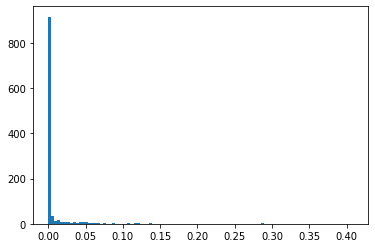

F1 score        : 0.9696106362773029
AUROC           : 0.9275449926542605
EER             : 0.12928501469147893
frr_at_eer      : 0.15625
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   1   ####################
(array([0, 1]), array([2262,   10]))
RF


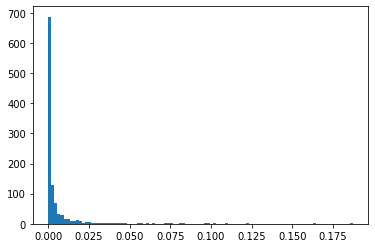

F1 score        : 0.9715639810426541
AUROC           : 0.8433658536585366
EER             : 0.17365853658536584
frr_at_eer      : 0.23333333333333334
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   2   ####################
(array([0, 1]), array([2248,   10]))
RF


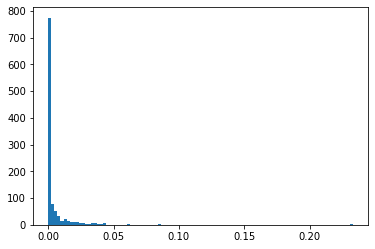

F1 score        : 0.9671584959543075
AUROC           : 0.6875142645212827
EER             : 0.32677165354330706
frr_at_eer      : 0.36231884057971014
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   3   ####################
(array([0, 1]), array([2279,   10]))
RF


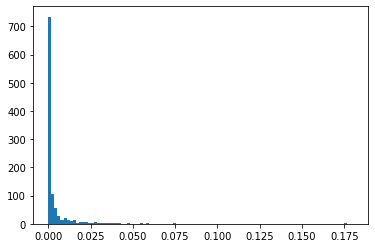

F1 score        : 0.9744801512287335
AUROC           : 0.9309731652117684
EER             : 0.09602327837051407
frr_at_eer      : 0.12962962962962962
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   4   ####################
(array([0, 1]), array([2180,   10]))
RF


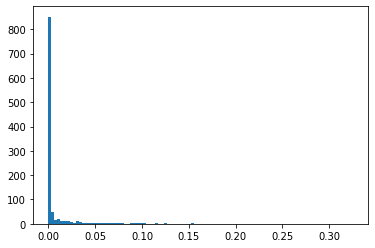

F1 score        : 0.9496611810261375
AUROC           : 0.8998127891476515
EER             : 0.1488277268093782
frr_at_eer      : 0.16346153846153846
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   5   ####################
(array([0, 1]), array([2248,   10]))
RF


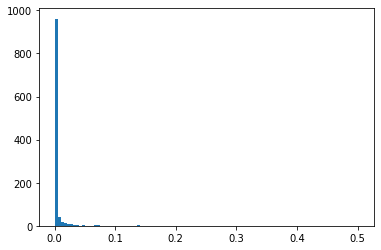

F1 score        : 0.49764810875735593
AUROC           : 0.9213159746657285
EER             : 0.1270935960591133
frr_at_eer      : 0.12857142857142856
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   6   ####################
(array([0, 1]), array([2253,   10]))
RF


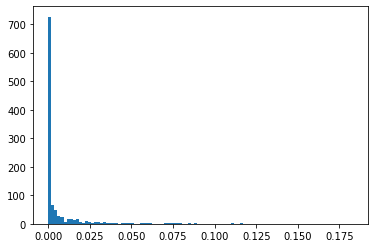

F1 score        : 0.9700996677740864
AUROC           : 0.8818531979001647
EER             : 0.1888454011741683
frr_at_eer      : 0.19047619047619047
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   7   ####################
(array([0, 1]), array([2245,   10]))
RF


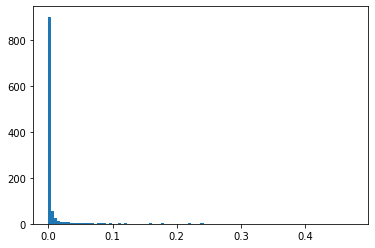

F1 score        : 0.9666666666666666
AUROC           : 0.8915482054890922
EER             : 0.1605911330049261
frr_at_eer      : 0.17142857142857143
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   8   ####################
(array([0, 1]), array([2311,   10]))
RF


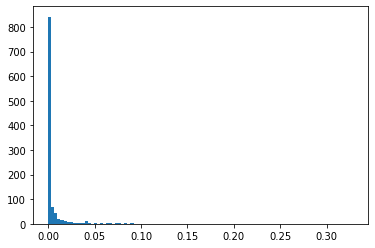

F1 score        : 0.9826535396155649
AUROC           : 0.9199762739839077
EER             : 0.10877862595419847
frr_at_eer      : 0.13513513513513514
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   9   ####################
(array([0, 1]), array([2314,   10]))
RF


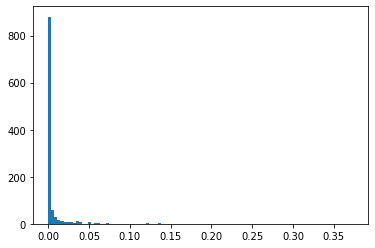

F1 score        : 0.9836065573770492
AUROC           : 0.8791836734693877
EER             : 0.14857142857142858
frr_at_eer      : 0.17142857142857143
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   10   ####################
(array([0, 1]), array([2245,   10]))
RF


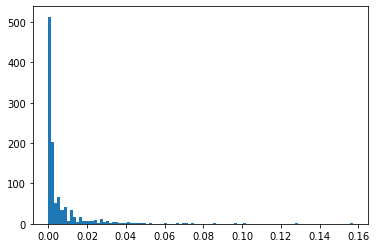

F1 score        : 0.967649857278782
AUROC           : 0.7086297645902019
EER             : 0.3215339233038348
frr_at_eer      : 0.38235294117647056
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   11   ####################
(array([0, 1]), array([2211,   10]))
RF


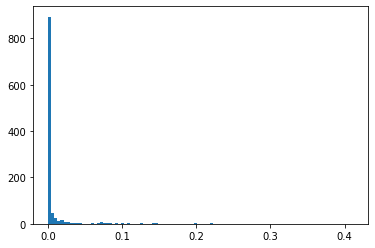

F1 score        : 0.9592326139088729
AUROC           : 0.9357941176470588
EER             : 0.117
frr_at_eer      : 0.12941176470588237
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   12   ####################
(array([0, 1]), array([2239,   10]))
RF


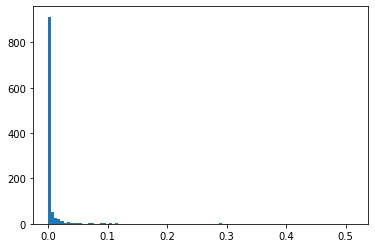

F1 score        : 0.4963379409944295
AUROC           : 0.9166847149277166
EER             : 0.13043478260869565
frr_at_eer      : 0.1643835616438356
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   13   ####################
(array([0, 1]), array([2236,   10]))
RF


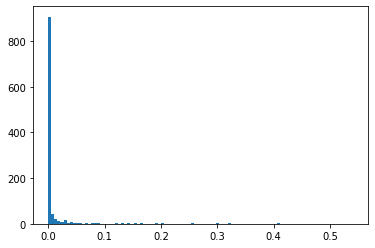

F1 score        : 0.4954883627406625
AUROC           : 0.9788580858085809
EER             : 0.05247524752475247
frr_at_eer      : 0.06666666666666667
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   14   ####################
(array([0, 1]), array([2230,   10]))
RF


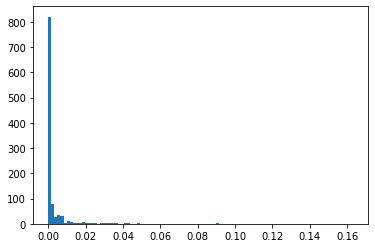

F1 score        : 0.9617224880382775
AUROC           : 0.8838495024875622
EER             : 0.14925373134328357
frr_at_eer      : 0.2125
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   15   ####################
(array([0, 1]), array([2230,   10]))
RF


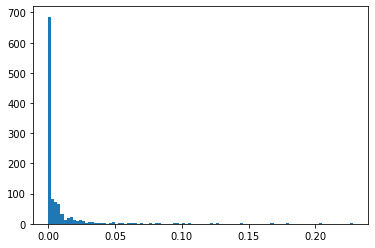

F1 score        : 0.962715105162524
AUROC           : 0.8149173732589821
EER             : 0.21648460774577954
frr_at_eer      : 0.3076923076923077
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   0   ####################
(array([0, 1]), array([2254,   10]))
RF


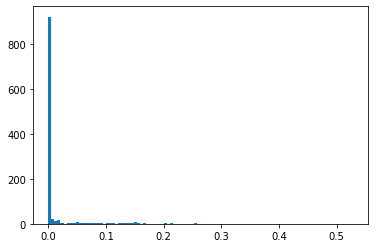

F1 score        : 0.5004202448382971
AUROC           : 0.9476922135161607
EER             : 0.0940254652301665
frr_at_eer      : 0.109375
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   1   ####################
(array([0, 1]), array([2262,   10]))
RF


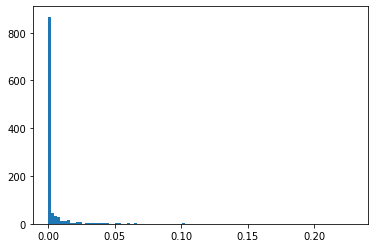

F1 score        : 0.9715639810426541
AUROC           : 0.9063739837398375
EER             : 0.11902439024390243
frr_at_eer      : 0.16666666666666666
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   2   ####################
(array([0, 1]), array([2248,   10]))
RF


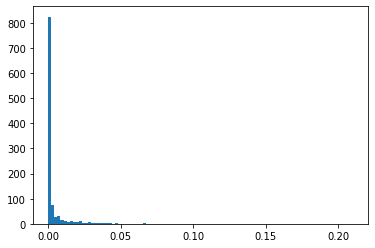

F1 score        : 0.9671584959543075
AUROC           : 0.7911888052036973
EER             : 0.2106299212598425
frr_at_eer      : 0.3188405797101449
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   3   ####################
(array([0, 1]), array([2279,   10]))
RF


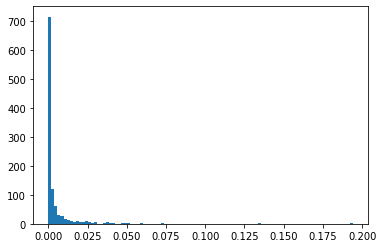

F1 score        : 0.9744801512287335
AUROC           : 0.9207439738477565
EER             : 0.14064015518913675
frr_at_eer      : 0.16666666666666666
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   4   ####################
(array([0, 1]), array([2180,   10]))
RF


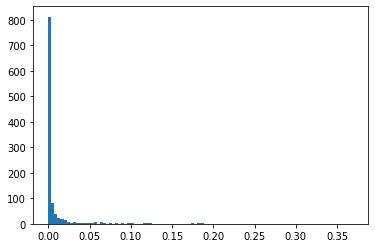

F1 score        : 0.9496611810261375
AUROC           : 0.9410922920097232
EER             : 0.14271151885830785
frr_at_eer      : 0.14423076923076922
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   5   ####################
(array([0, 1]), array([2248,   10]))
RF


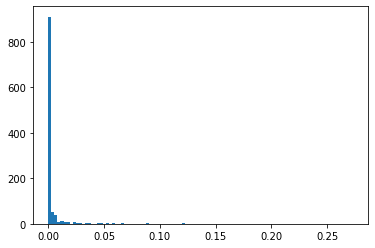

F1 score        : 0.9666666666666666
AUROC           : 0.7818508092892329
EER             : 0.1665024630541872
frr_at_eer      : 0.32857142857142857
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   6   ####################
(array([0, 1]), array([2253,   10]))
RF


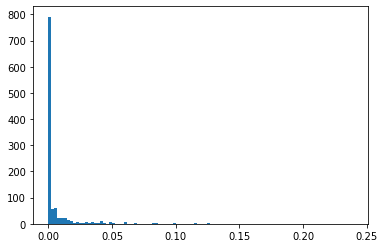

F1 score        : 0.9700996677740864
AUROC           : 0.9487854502531606
EER             : 0.11937377690802348
frr_at_eer      : 0.12698412698412698
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   7   ####################
(array([0, 1]), array([2245,   10]))
RF


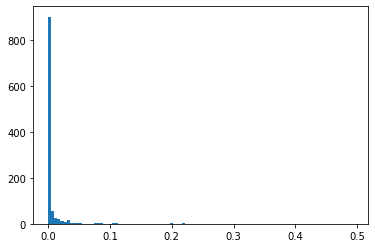

F1 score        : 0.9666666666666666
AUROC           : 0.8829697396199858
EER             : 0.17438423645320197
frr_at_eer      : 0.24285714285714285
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   8   ####################
(array([0, 1]), array([2311,   10]))
RF


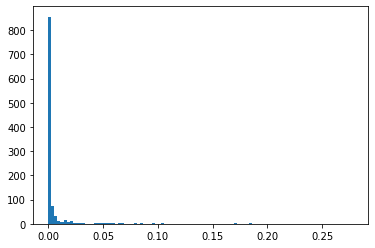

F1 score        : 0.9826535396155649
AUROC           : 0.9579121105838664
EER             : 0.10591603053435114
frr_at_eer      : 0.13513513513513514
far at zero frr : 0.36354961832061067
frr at 'zero' frr : 0.0
################   9   ####################
(array([0, 1]), array([2314,   10]))
RF


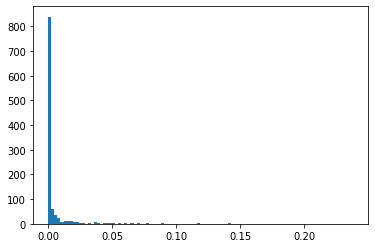

F1 score        : 0.9836065573770492
AUROC           : 0.9353469387755102
EER             : 0.10666666666666667
frr_at_eer      : 0.17142857142857143
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   10   ####################
(array([0, 1]), array([2245,   10]))
RF


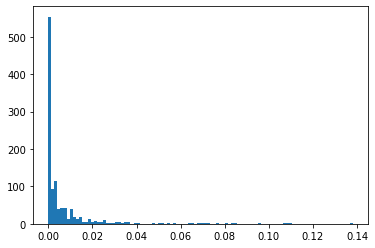

F1 score        : 0.967649857278782
AUROC           : 0.7828387992365087
EER             : 0.2713864306784661
frr_at_eer      : 0.3088235294117647
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   11   ####################
(array([0, 1]), array([2211,   10]))
RF


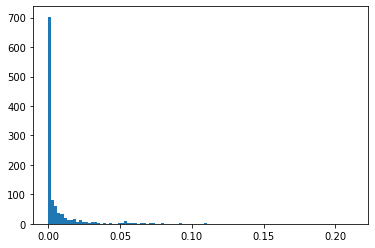

F1 score        : 0.9592326139088729
AUROC           : 0.9293235294117648
EER             : 0.133
frr_at_eer      : 0.17647058823529413
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   12   ####################
(array([0, 1]), array([2239,   10]))
RF


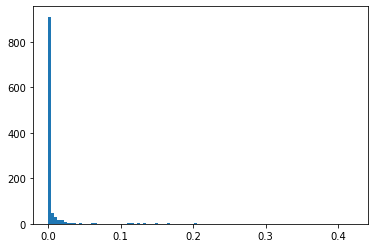

F1 score        : 0.9651883643299952
AUROC           : 0.9185188694569278
EER             : 0.11264822134387352
frr_at_eer      : 0.1780821917808219
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   13   ####################
(array([0, 1]), array([2236,   10]))
RF


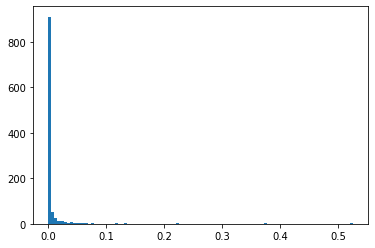

F1 score        : 0.5336553886760015
AUROC           : 0.9555247524752475
EER             : 0.0900990099009901
frr_at_eer      : 0.12
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   14   ####################
(array([0, 1]), array([2230,   10]))
RF


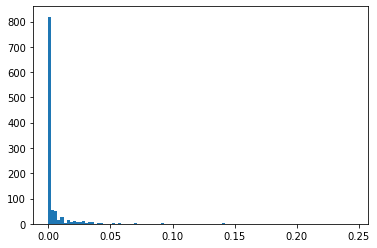

F1 score        : 0.9617224880382775
AUROC           : 0.9426616915422885
EER             : 0.1253731343283582
frr_at_eer      : 0.15
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   15   ####################
(array([0, 1]), array([2230,   10]))
RF


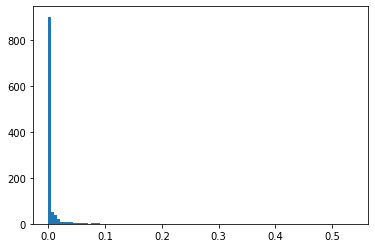

F1 score        : 0.4942459849021424
AUROC           : 0.8625709775163598
EER             : 0.21946375372393248
frr_at_eer      : 0.2564102564102564
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   0   ####################
(array([0, 1]), array([2254,   10]))
RF


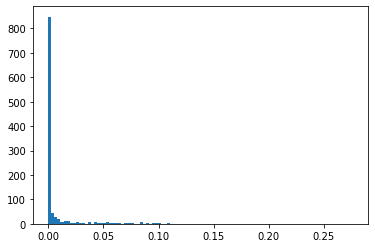

F1 score        : 0.9696106362773029
AUROC           : 0.9735400342801176
EER             : 0.07737512242899118
frr_at_eer      : 0.078125
far at zero frr : 0.21449559255631734
frr at 'zero' frr : 0.0
################   1   ####################
(array([0, 1]), array([2262,   10]))
RF


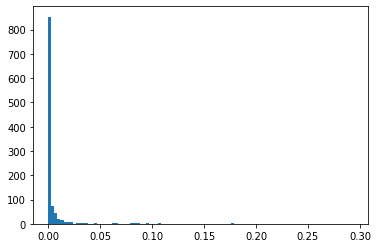

F1 score        : 0.9715639810426541
AUROC           : 0.818089430894309
EER             : 0.18341463414634146
frr_at_eer      : 0.26666666666666666
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   2   ####################
(array([0, 1]), array([2248,   10]))
RF


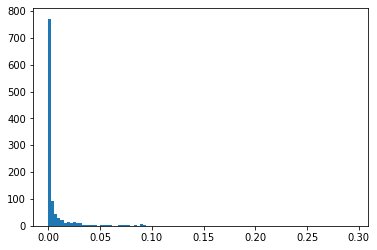

F1 score        : 0.9671584959543075
AUROC           : 0.7269128723040054
EER             : 0.26476377952755903
frr_at_eer      : 0.34782608695652173
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   3   ####################
(array([0, 1]), array([2279,   10]))
RF


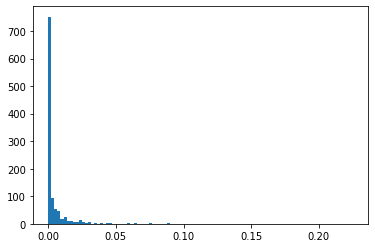

F1 score        : 0.9744801512287335
AUROC           : 0.8932625642130977
EER             : 0.1600387972841901
frr_at_eer      : 0.18518518518518517
far at zero frr : 0.5373423860329777
frr at 'zero' frr : 0.0
################   4   ####################
(array([0, 1]), array([2180,   10]))
RF


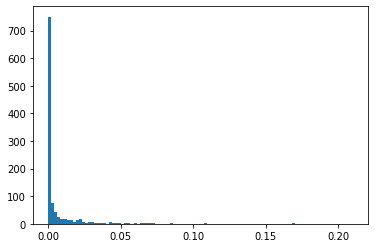

F1 score        : 0.9496611810261375
AUROC           : 0.8892074413863406
EER             : 0.13149847094801223
frr_at_eer      : 0.17307692307692307
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   5   ####################
(array([0, 1]), array([2248,   10]))
RF


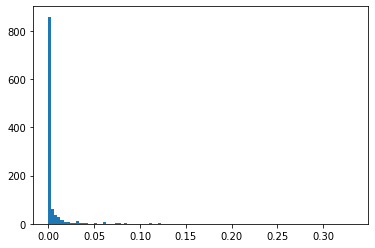

F1 score        : 0.9666666666666666
AUROC           : 0.9618578465869106
EER             : 0.08275862068965517
frr_at_eer      : 0.08571428571428572
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   6   ####################
(array([0, 1]), array([2253,   10]))
RF


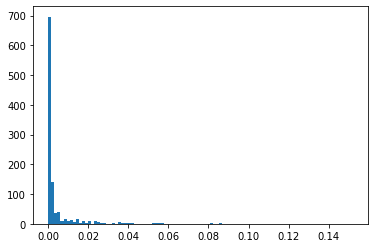

F1 score        : 0.9700996677740864
AUROC           : 0.9510685552759917
EER             : 0.11643835616438356
frr_at_eer      : 0.12698412698412698
far at zero frr : 0.4726027397260274
frr at 'zero' frr : 0.0
################   7   ####################
(array([0, 1]), array([2245,   10]))
RF


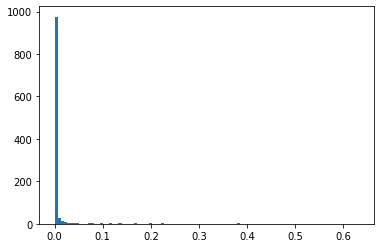

F1 score        : 0.5115718673869293
AUROC           : 0.7961154116819141
EER             : 0.22857142857142856
frr_at_eer      : 0.3
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   8   ####################
(array([0, 1]), array([2311,   10]))
RF


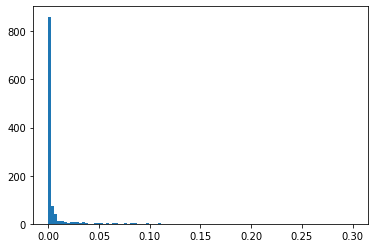

F1 score        : 0.9826535396155649
AUROC           : 0.9340700433257685
EER             : 0.11259541984732824
frr_at_eer      : 0.16216216216216217
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   9   ####################
(array([0, 1]), array([2314,   10]))
RF


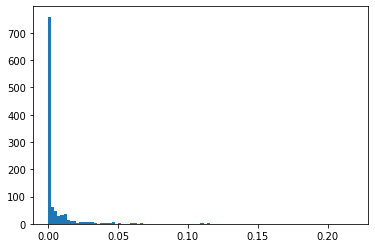

F1 score        : 0.9836065573770492
AUROC           : 0.899170068027211
EER             : 0.15047619047619049
frr_at_eer      : 0.17142857142857143
far at zero frr : 0.4819047619047619
frr at 'zero' frr : 0.0
################   10   ####################
(array([0, 1]), array([2245,   10]))
RF


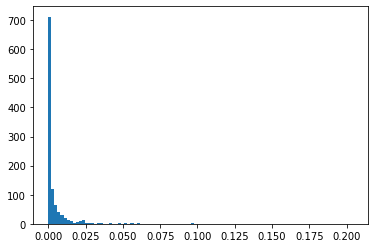

F1 score        : 0.967649857278782
AUROC           : 0.8740167158308751
EER             : 0.19469026548672566
frr_at_eer      : 0.20588235294117646
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   11   ####################
(array([0, 1]), array([2211,   10]))
RF


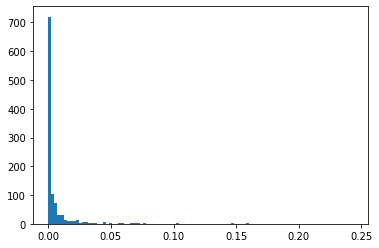

F1 score        : 0.9592326139088729
AUROC           : 0.9013176470588236
EER             : 0.119
frr_at_eer      : 0.17647058823529413
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   12   ####################
(array([0, 1]), array([2239,   10]))
RF


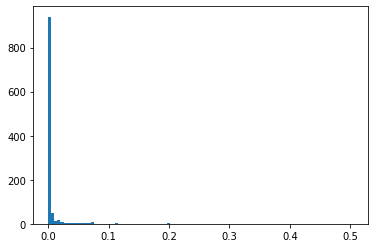

F1 score        : 0.4963379409944295
AUROC           : 0.9551410471601061
EER             : 0.09189723320158102
frr_at_eer      : 0.1095890410958904
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   13   ####################
(array([0, 1]), array([2236,   10]))
RF


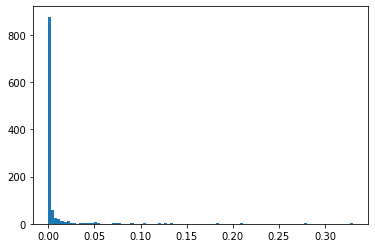

F1 score        : 0.964200477326969
AUROC           : 0.977075907590759
EER             : 0.061386138613861385
frr_at_eer      : 0.09333333333333334
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   14   ####################
(array([0, 1]), array([2230,   10]))
RF


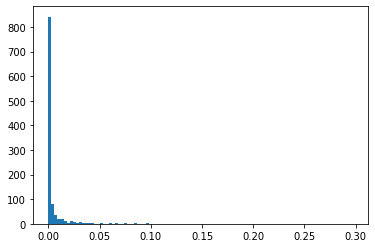

F1 score        : 0.9617224880382775
AUROC           : 0.9630721393034827
EER             : 0.09253731343283582
frr_at_eer      : 0.1125
far at zero frr : 0.3482587064676617
frr at 'zero' frr : 0.0
################   15   ####################
(array([0, 1]), array([2230,   10]))
RF


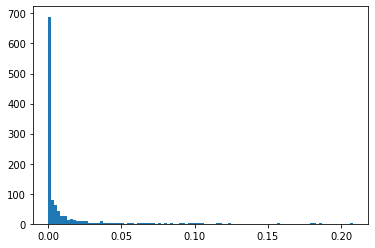

F1 score        : 0.962715105162524
AUROC           : 0.8882247345504546
EER             : 0.1926514399205561
frr_at_eer      : 0.21794871794871795
far at zero frr : 0.5342601787487586
frr at 'zero' frr : 0.0
################   0   ####################
(array([0, 1]), array([2254,   10]))
RF


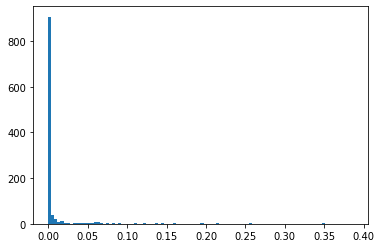

F1 score        : 0.9696106362773029
AUROC           : 0.9430781709108718
EER             : 0.10381978452497552
frr_at_eer      : 0.140625
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   1   ####################
(array([0, 1]), array([2262,   10]))
RF


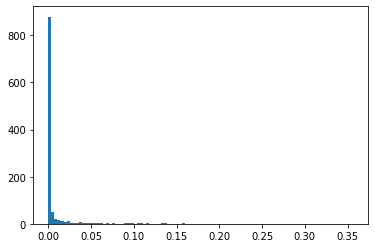

F1 score        : 0.9715639810426541
AUROC           : 0.9415121951219512
EER             : 0.10829268292682927
frr_at_eer      : 0.11666666666666667
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   2   ####################
(array([0, 1]), array([2248,   10]))
RF


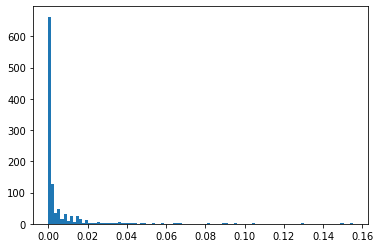

F1 score        : 0.9671584959543075
AUROC           : 0.6904028300810225
EER             : 0.2952755905511811
frr_at_eer      : 0.4057971014492754
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   3   ####################
(array([0, 1]), array([2279,   10]))
RF


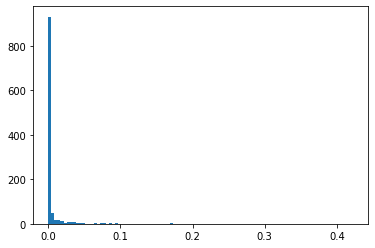

F1 score        : 0.9744801512287335
AUROC           : 0.945710744692316
EER             : 0.10184287099903007
frr_at_eer      : 0.1111111111111111
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   4   ####################
(array([0, 1]), array([2180,   10]))
RF


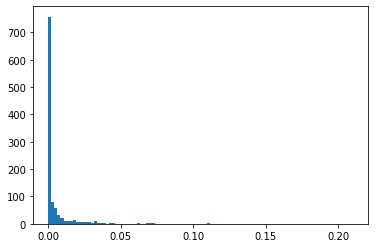

F1 score        : 0.9496611810261375
AUROC           : 0.9100260722967145
EER             : 0.1345565749235474
frr_at_eer      : 0.17307692307692307
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   5   ####################
(array([0, 1]), array([2248,   10]))
RF


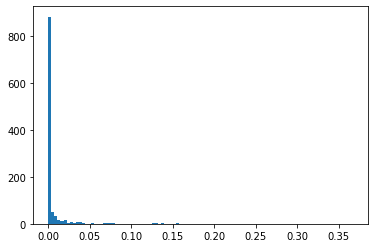

F1 score        : 0.9666666666666666
AUROC           : 0.9623152709359607
EER             : 0.09852216748768473
frr_at_eer      : 0.14285714285714285
far at zero frr : 0.3536945812807882
frr at 'zero' frr : 0.0
################   6   ####################
(array([0, 1]), array([2253,   10]))
RF


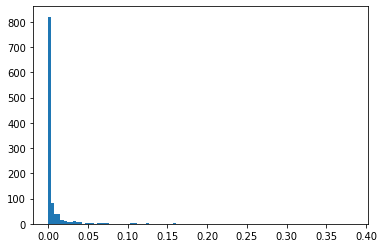

F1 score        : 0.9700996677740864
AUROC           : 0.9250302860870376
EER             : 0.14481409001956946
frr_at_eer      : 0.15873015873015872
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   7   ####################
(array([0, 1]), array([2245,   10]))
RF


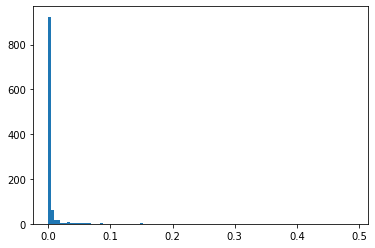

F1 score        : 0.9666666666666666
AUROC           : 0.8710978184377198
EER             : 0.1891625615763547
frr_at_eer      : 0.2
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   8   ####################
(array([0, 1]), array([2311,   10]))
RF


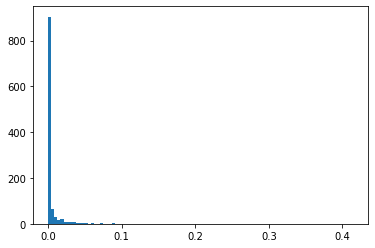

F1 score        : 0.9826535396155649
AUROC           : 0.8932587167319991
EER             : 0.1650763358778626
frr_at_eer      : 0.1891891891891892
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   9   ####################
(array([0, 1]), array([2314,   10]))
RF


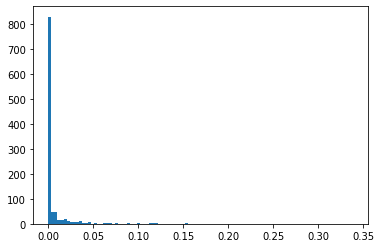

F1 score        : 0.9836065573770492
AUROC           : 0.9302993197278913
EER             : 0.12
frr_at_eer      : 0.17142857142857143
far at zero frr : 0.35904761904761906
frr at 'zero' frr : 0.0
################   10   ####################
(array([0, 1]), array([2245,   10]))
RF


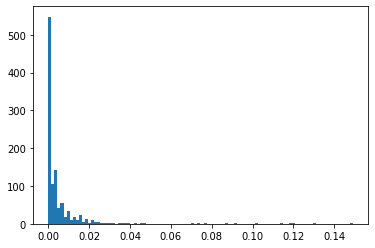

F1 score        : 0.967649857278782
AUROC           : 0.723444097402973
EER             : 0.3048180924287119
frr_at_eer      : 0.3382352941176471
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   11   ####################
(array([0, 1]), array([2211,   10]))
RF


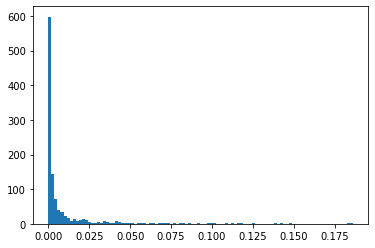

F1 score        : 0.9592326139088729
AUROC           : 0.9203941176470589
EER             : 0.141
frr_at_eer      : 0.15294117647058825
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   12   ####################
(array([0, 1]), array([2239,   10]))
RF


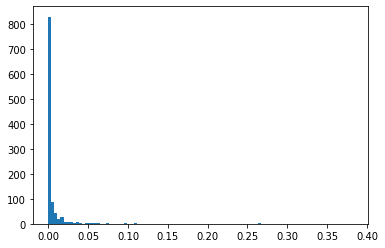

F1 score        : 0.9651883643299952
AUROC           : 0.9230399588499647
EER             : 0.14624505928853754
frr_at_eer      : 0.1506849315068493
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   13   ####################
(array([0, 1]), array([2236,   10]))
RF


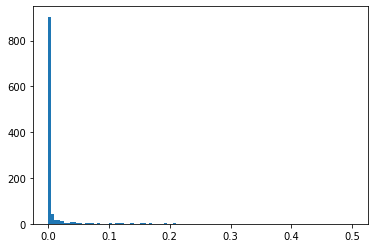

F1 score        : 0.4954883627406625
AUROC           : 0.990039603960396
EER             : 0.048514851485148516
frr_at_eer      : 0.05333333333333334
far at zero frr : 0.12376237623762376
frr at 'zero' frr : 0.0
################   14   ####################
(array([0, 1]), array([2230,   10]))
RF


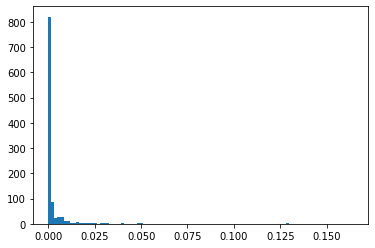

F1 score        : 0.9617224880382775
AUROC           : 0.9263121890547265
EER             : 0.15223880597014924
frr_at_eer      : 0.1625
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   15   ####################
(array([0, 1]), array([2230,   10]))
RF


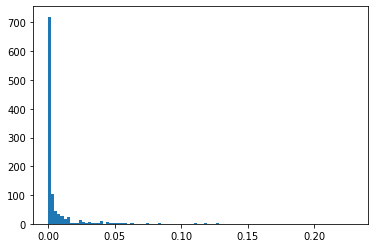

F1 score        : 0.962715105162524
AUROC           : 0.76587604715708
EER             : 0.3098311817279047
frr_at_eer      : 0.32051282051282054
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   0   ####################
(array([0, 1]), array([2254,   10]))
RF


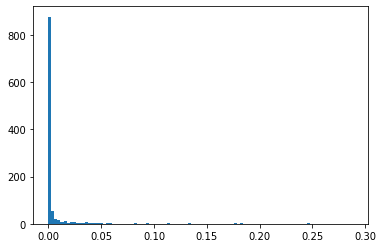

F1 score        : 0.9696106362773029
AUROC           : 0.8972744245837414
EER             : 0.12830558276199805
frr_at_eer      : 0.15625
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   1   ####################
(array([0, 1]), array([2262,   10]))
RF


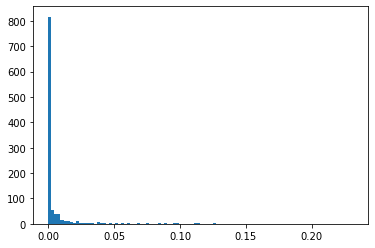

F1 score        : 0.9715639810426541
AUROC           : 0.9158780487804878
EER             : 0.144390243902439
frr_at_eer      : 0.18333333333333332
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   2   ####################
(array([0, 1]), array([2248,   10]))
RF


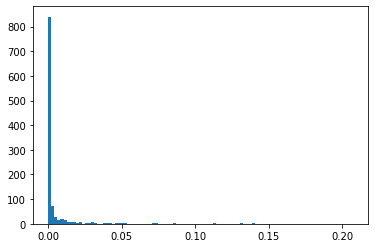

F1 score        : 0.9671584959543075
AUROC           : 0.6825002852904256
EER             : 0.34744094488188976
frr_at_eer      : 0.34782608695652173
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   3   ####################
(array([0, 1]), array([2279,   10]))
RF


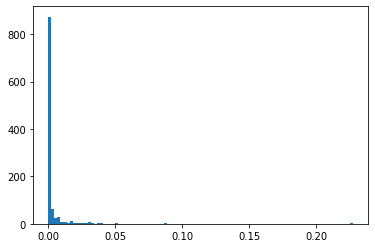

F1 score        : 0.9744801512287335
AUROC           : 0.9042730897726048
EER             : 0.16197866149369544
frr_at_eer      : 0.18518518518518517
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   4   ####################
(array([0, 1]), array([2180,   10]))
RF


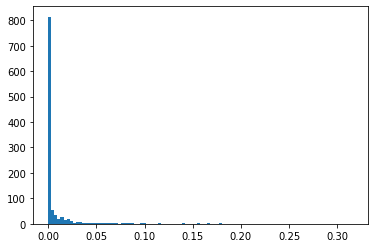

F1 score        : 0.9496611810261375
AUROC           : 0.9496883086332628
EER             : 0.11518858307849134
frr_at_eer      : 0.11538461538461539
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   5   ####################
(array([0, 1]), array([2248,   10]))
RF


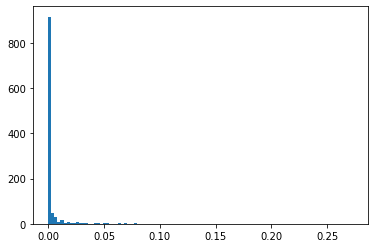

F1 score        : 0.9666666666666666
AUROC           : 0.8544968332160451
EER             : 0.1477832512315271
frr_at_eer      : 0.2
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   6   ####################
(array([0, 1]), array([2253,   10]))
RF


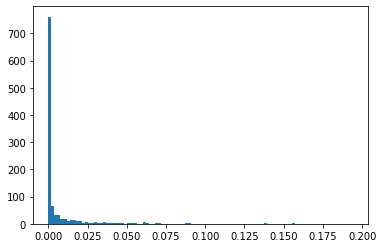

F1 score        : 0.9700996677740864
AUROC           : 0.9214270182959029
EER             : 0.13405088062622308
frr_at_eer      : 0.15873015873015872
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   7   ####################
(array([0, 1]), array([2245,   10]))
RF


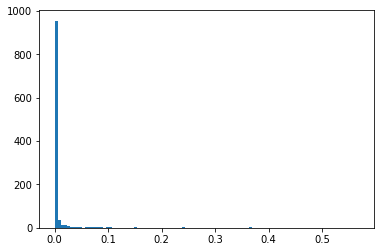

F1 score        : 0.5115718673869293
AUROC           : 0.8628219563687544
EER             : 0.15862068965517243
frr_at_eer      : 0.2714285714285714
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   8   ####################
(array([0, 1]), array([2311,   10]))
RF


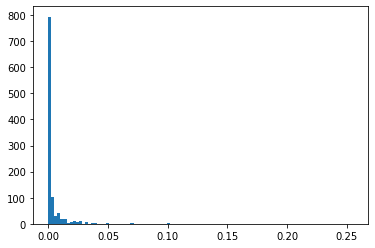

F1 score        : 0.9826535396155649
AUROC           : 0.9048122550030948
EER             : 0.1364503816793893
frr_at_eer      : 0.16216216216216217
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   9   ####################
(array([0, 1]), array([2314,   10]))
RF


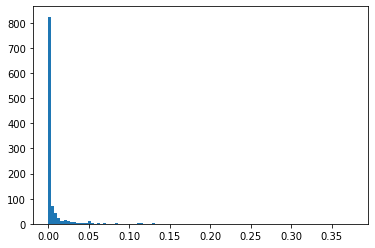

F1 score        : 0.9836065573770492
AUROC           : 0.9349115646258502
EER             : 0.14
frr_at_eer      : 0.14285714285714285
far at zero frr : 0.21428571428571427
frr at 'zero' frr : 0.0
################   10   ####################
(array([0, 1]), array([2245,   10]))
RF


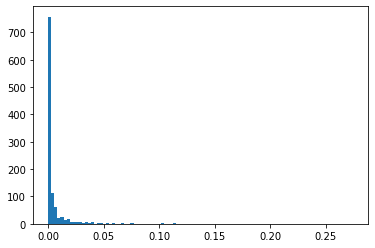

F1 score        : 0.967649857278782
AUROC           : 0.854314882295101
EER             : 0.1887905604719764
frr_at_eer      : 0.22058823529411764
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   11   ####################
(array([0, 1]), array([2211,   10]))
RF


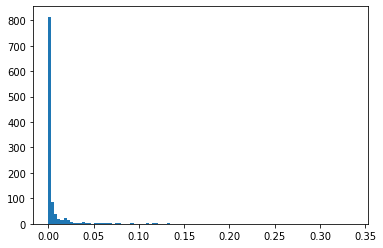

F1 score        : 0.9592326139088729
AUROC           : 0.9285588235294118
EER             : 0.115
frr_at_eer      : 0.16470588235294117
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   12   ####################
(array([0, 1]), array([2239,   10]))
RF


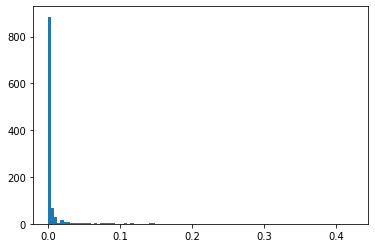

F1 score        : 0.9651883643299952
AUROC           : 0.9512629270669771
EER             : 0.0958498023715415
frr_at_eer      : 0.1095890410958904
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   13   ####################
(array([0, 1]), array([2236,   10]))
RF


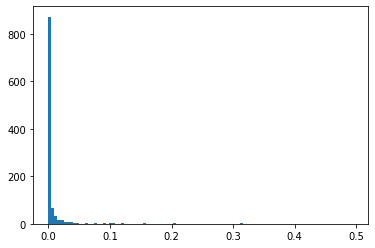

F1 score        : 0.964200477326969
AUROC           : 0.946052805280528
EER             : 0.10198019801980197
frr_at_eer      : 0.13333333333333333
far at zero frr : 1.0
frr at 'zero' frr : 0.0
################   14   ####################
(array([0, 1]), array([2230,   10]))
RF


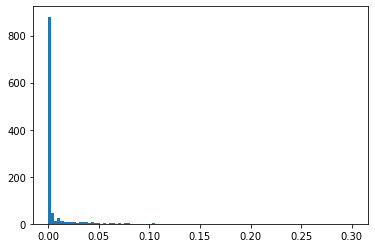

F1 score        : 0.9617224880382775
AUROC           : 0.9607276119402984
EER             : 0.09751243781094528
frr_at_eer      : 0.1125
far at zero frr : 0.281592039800995
frr at 'zero' frr : 0.0
################   15   ####################
(array([0, 1]), array([2230,   10]))
RF


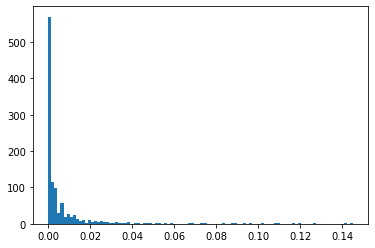

F1 score        : 0.962715105162524
AUROC           : 0.8842334428233137
EER             : 0.21052631578947367
frr_at_eer      : 0.21794871794871795
far at zero frr : 0.5908639523336644
frr at 'zero' frr : 0.0


In [57]:
limit_data=True
limit_data_string = "_limit_10" if limit_data else ""   # limit_bal_longer = 40* weighting, split into 4, limit_10 = 10%
limit_terminals = False
save = True
if limit_terminals:
    limit_data_string += "_terminals"
if limit_data:
    weight_boost = 40   # 40 for limit 10, 40 for limit 20
else:
    weight_boost = 4
RF_CLASSIFIERS = 1000

class_weights = {0:1, 1:15 * weight_boost}

for repetition in range(5):
    for auth_user in range(16):
        print(f"################   {auth_user}   ####################")

        if limit_terminals:
            _map = (train_gesture_map == 1) & ((y_gesture.argmax(axis=1) == 3) )
            _test_map = (test_gesture_map == 1) & (y_gesture.argmax(axis=1) != 3)
        else:
            _map = (train_gesture_map == 1)
            _test_map = (test_gesture_map == 1)           

        data_train = x_data[_map]
        feature_data_train = feature_x_data[_map]
        data_test = x_data[_test_map]
        feature_data_test = feature_x_data[_test_map]
        labels_train = (y_user.argmax(axis=1) == auth_user)[_map].astype(int)
        labels_test = (y_user.argmax(axis=1) == auth_user)[_test_map].astype(int)

        ## Train and run RF model  ##
        
            
        
        standard_scaler = StandardScaler()
        
        if limit_data:
            np.random.seed(repetition)
            positive_data_indices = np.random.choice(np.nonzero(labels_train)[0], size=10, replace=False)
            val_map_all = np.zeros(len(labels_train))
            val_map_all[positive_data_indices] = 1
            
            limit_map = (val_map_all==1) | (labels_train == 0)
            
            shuffled_data_train, shuffled_labels_train = shuffle(feature_data_train[limit_map], labels_train[limit_map], random_state=repetition)
        else:
            shuffled_data_train, shuffled_labels_train = shuffle(feature_data_train, labels_train, random_state=repetition)
        
        print(np.unique(shuffled_labels_train, return_counts=True))
        
        shuffled_data_train = standard_scaler.fit_transform(shuffled_data_train)

        wa_model = RandomForestClassifier(n_estimators = RF_CLASSIFIERS, random_state = repetition, class_weight={0:1,1:1}).fit(shuffled_data_train, shuffled_labels_train)

        labels_pred = wa_model.predict(standard_scaler.transform(feature_data_test))
        labels_scores = wa_model.predict_proba(standard_scaler.transform(feature_data_test))[:, 1]

        if save: # 
            save_stats_dict(labels_pred, labels_scores, labels_test, f"RF{RF_CLASSIFIERS}_user={auth_user}_rep={repetition}{limit_data_string}")

        print("RF")
        show_evaluate_model(labels_test, labels_pred, labels_scores, verbose=1)
        
        
####################################
        
        ## Train and run DL models  ## 
        """
        if limit_data:
            np.random.seed(repetition)
            positive_data_indices = np.random.choice(np.nonzero(labels_train)[0], size=10, replace=False)
            val_map_all = np.zeros(len(labels_train))
            val_map_all[positive_data_indices] = 1
            
            limit_map = (val_map_all==1) | (labels_train == 0)
            
            shuffled_data_train, shuffled_labels_train = shuffle(data_train[limit_map], labels_train[limit_map], random_state=repetition)
        else:
            shuffled_data_train, shuffled_labels_train = shuffle(data_train, labels_train, random_state=repetition)
        
        
        
        scaler = CustomScaler()
        scaler.CHANNELS = 6
        shuffled_data_train = scaler.fit_and_transform(shuffled_data_train)
                       #)
        kFold = sklearn.model_selection.StratifiedKFold(n_splits=5)
        val_map = next(kFold.split(shuffled_data_train, shuffled_labels_train))[1]

        val_map_all = np.zeros(len(shuffled_labels_train))
        val_map_all[val_map] = 1

        val_map = val_map_all == 1
        
        print(np.unique(shuffled_labels_train[~val_map], return_counts=True))

        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=300,
                                                                   patience=150, restore_best_weights=True)

        for model_name in ["MLP", "GRU", "Conv", "simpleMix", "complexMix"]:
            
            if model_name == "MLP":
                model = get_mlp_model()
            elif model_name == "GRU":
                model = get_gru_model()
            elif model_name == "Conv":
                model = get_conv_model()
            elif model_name == "simpleMix":
                model = get_simple_mix_model()
            elif model_name == "complexMix":
                model = get_complex_mix_model()
            else:
                assert False, "Not a valid model string"

            model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

            history = model.fit(shuffled_data_train[~val_map], shuffled_labels_train[~val_map], epochs=1500,
                        batch_size=1024, verbose=0,
                        validation_data=(shuffled_data_train[val_map], shuffled_labels_train[val_map]),
                       class_weight=class_weights, 
                   callbacks=[early_stopping_callback])

            
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'val'], loc='upper left')
            plt.show()

            plt.clf()
            

            with suppress_stdout():

                with open(f'data/models/DL/{model_name}_user={auth_user}_rep={repetition}{limit_data_string}.pickle', 'wb') as f:
                    pickle.dump(model, f)

                with open(f'data/stats/auth/{model_name}_user={auth_user}_history_rep={repetition}{limit_data_string}.pickle', 'wb') as f:
                    pickle.dump(history.history, f)


            labels_scores = model.predict(scaler.transform(data_test)).squeeze()
            labels_pred = (labels_scores >= 0.5).astype(int)

            if save:
                save_stats_dict(labels_pred, labels_scores, labels_test, f"{model_name}_user={auth_user}_rep={repetition}{limit_data_string}")
            print(model_name)
            show_evaluate_model(labels_test, labels_pred, labels_scores, verbose=1)
        """

In [58]:
print("Done")

Done


# Accessing saved results

In [30]:
handle = "complexConv_user=2_rep=5"
with open(f'data/stats/auth/{handle}.pickle', 'rb') as f:
    labels_dict = pickle.load(f)
    stats_dict = show_evaluate_model(labels_dict["labels_test"],
                                     labels_dict["labels_pred"],
                                     labels_dict["labels_scores"], verbose=0)
stats_dict

{'fmeasure': 0.5919940937207834,
 'auroc': 0.8198961542850621,
 'eer_theta': 0.0036525303,
 'eer': 0.2440944881889764,
 'frr_at_eer': 0.2463768115942029,
 'far_theta': 1.969508e-06,
 'far': 0.9124015748031497,
 'frr_at_zero_frr': 0.0,
 'accuracy': 0.8995391705069125}

In [31]:
mins = []
for user in range(16):
    print(user)
    pairs = []
    for rep in range(5):
        handle1 = f"complexMix_user={user}_history_rep={rep}"
        handle2 = f"complexMix_user={user}_rep={rep}"
        with open(f'data/stats/auth/{handle1}.pickle', 'rb') as f:

            with suppress_stdout():
                history = pickle.load(f)


        with open(f'data/stats/auth/{handle2}.pickle', 'rb') as f:
            labels_dict = pickle.load(f)
            stats_dict = show_evaluate_model(labels_dict["labels_test"],
                                             labels_dict["labels_pred"],
                                             labels_dict["labels_scores"], verbose=0)
        #print(min(history.history["val_loss"]), stats_dict["eer"])
        pairs.append((min(history["val_loss"]), stats_dict["far"]))
    print(min(pairs))
    print(max(pairs))
    mins.append(min(pairs)[1])
print(np.mean(np.array(mins)))

0
(0.053405050188302994, 0.4671890303623898)
(0.0989183634519577, 0.41625857002938293)
1
(0.08413390070199966, 0.22048780487804878)
(0.14468508958816528, 0.46439024390243905)
2
(0.1736104041337967, 0.9320866141732284)
(0.22912326455116272, 0.9291338582677166)
3
(0.09050904214382172, 0.39864209505334625)
(0.17857201397418976, 0.4713870029097963)
4
(0.06574883311986923, 0.6758409785932722)
(0.151594340801239, 0.20489296636085627)
5
(0.014080768451094627, 0.6344827586206897)
(0.07459704577922821, 0.33497536945812806)
6
(0.03193271905183792, 0.29354207436399216)
(0.11923642456531525, 0.9197651663405088)
7
(0.018032532185316086, 0.10837438423645321)
(0.05254821479320526, 0.042364532019704436)
8
(0.03979788348078728, 0.6307251908396947)
(0.08168257772922516, 0.11354961832061068)
9
(0.08142661303281784, 0.045714285714285714)
(0.1777920424938202, 0.7714285714285715)
10
(0.13692983984947205, 0.4464110127826942)
(0.23591111600399017, 0.9990167158308751)
11
(0.12419722974300385, 0.501)
(0.2793215

In [32]:
print(np.mean(np.array(mins)))

0.36078581679000377


In [61]:
from prettytable import PrettyTable

model_names = ["RF100_weighted","RF1000", "MLP", "GRU", "Conv", "simpleMix", "complexMix"]

all_stats_user = {}
for model_name in model_names:
    
    
    for user in range(16):
        stats = {key:[] for key in stats_dict}
        all_stats_user[model_name + f"_{user}"] = stats
        for repetition in range(5):
            
                
            handle = f"{model_name}_user={user}_rep={repetition}"
            with open(f'data/stats/auth/{handle}.pickle', 'rb') as f:
                labels_dict = pickle.load(f)
                stats_dict = show_evaluate_model(labels_dict["labels_test"],
                                                 labels_dict["labels_pred"],
                                                 labels_dict["labels_scores"], verbose=0)
                for key in stats_dict:
                    stats[key].append(stats_dict[key])

In [62]:
x = PrettyTable()

model_name = "RF1000"

x.field_names =  ['user', 'fmeasure', 'auroc', 'eer_theta', 'eer', 'frr_at_eer', 'far_theta', 'far',  'accuracy'] # 'frr_at_zero_frr',
print(x.field_names)
for user in range(16):
    row = [user]
    for key in all_stats_user[f"{model_name}_{user}"]:
        if key not in ["frr_at_zero_frr"]:
            array = np.array(all_stats_user[f"{model_name}_{user}"][key])
            mean = round(float(np.mean(array)), 3)
            std = round(float(np.std(array)),3)
            row.append(f"{mean} ") # {std}
    
    x.add_row(row)

print(x)

['user', 'fmeasure', 'auroc', 'eer_theta', 'eer', 'frr_at_eer', 'far_theta', 'far', 'accuracy']
+------+----------+--------+-----------+--------+------------+-----------+--------+----------+
| user | fmeasure | auroc  | eer_theta |  eer   | frr_at_eer | far_theta |  far   | accuracy |
+------+----------+--------+-----------+--------+------------+-----------+--------+----------+
|  0   |  0.775   | 0.967  |   0.125   | 0.085  |    0.1     |   0.013   | 0.388  |  0.959   |
|  1   |  0.664   | 0.964  |   0.149   | 0.084  |   0.107    |   0.036   | 0.374  |  0.956   |
|  2   |  0.512   | 0.811  |   0.061   | 0.276  |   0.287    |   0.005   | 0.796  |  0.938   |
|  3   |  0.588   | 0.953  |   0.12    | 0.089  |   0.104    |   0.002   | 0.729  |  0.956   |
|  4   |  0.705   | 0.943  |   0.117   | 0.133  |   0.138    |   0.023   | 0.481  |  0.931   |
|  5   |  0.688   | 0.991  |   0.173   | 0.039  |   0.043    |   0.127   | 0.061  |  0.952   |
|  6   |  0.862   | 0.978  |   0.209   | 0.052  |

### Comparison of different models

In [76]:

model_names = ["RF100","RF1000_weighted", "MLP", "GRU", "Conv", "simpleMix", "complexMix"]

all_stats = {}
for model_name in model_names:
    stats = {key:[] for key in stats_dict}
    all_stats[model_name] = stats
    for user in range(16):
        for repetition in range(5):


            handle = f"{model_name}_user={user}_rep={repetition}"
            with open(f'data/stats/auth/{handle}.pickle', 'rb') as f:
                labels_dict = pickle.load(f)
                stats_dict = show_evaluate_model(labels_dict["labels_test"],
                                                 labels_dict["labels_pred"],
                                                 labels_dict["labels_scores"], verbose=0)
                for key in stats_dict:
                    stats[key].append(stats_dict[key])

"""
model_names = ["RF", "MLP", "LSTM", "simpleConv", "complexConv", "ConvLSTM"]

all_stats = {}
for model_name in model_names:
    stats = {key:[] for key in stats_dict}
    all_stats[model_name] = stats
    for user in range(16):
        for repetition in range(6):
            test = []
            pred = []
            scores = []
                
            handle = f"{model_name}_user={user}_rep={repetition}"
            with open(f'data/stats/auth/{handle}.pickle', 'rb') as f:
                labels_dict = pickle.load(f)
                stats_dict = show_evaluate_model(labels_dict["labels_test"],
                                                 labels_dict["labels_pred"],
                                                 labels_dict["labels_scores"], verbose=0)
                for key in stats_dict:
                    stats[key].append(stats_dict[key])
"""

'\nmodel_names = ["RF", "MLP", "LSTM", "simpleConv", "complexConv", "ConvLSTM"]\n\nall_stats = {}\nfor model_name in model_names:\n    stats = {key:[] for key in stats_dict}\n    all_stats[model_name] = stats\n    for user in range(16):\n        for repetition in range(6):\n            test = []\n            pred = []\n            scores = []\n                \n            handle = f"{model_name}_user={user}_rep={repetition}"\n            with open(f\'data/stats/auth/{handle}.pickle\', \'rb\') as f:\n                labels_dict = pickle.load(f)\n                stats_dict = show_evaluate_model(labels_dict["labels_test"],\n                                                 labels_dict["labels_pred"],\n                                                 labels_dict["labels_scores"], verbose=0)\n                for key in stats_dict:\n                    stats[key].append(stats_dict[key])\n'

In [77]:
from math import log10, floor
round_sig = lambda x, n: x if x == 0 else round(x, -int(floor(log10(abs(x)))) + (n - 1))

from prettytable import PrettyTable

x = PrettyTable()
x.field_names =  ['model', 'fmeasure', 'auroc', 'eer_theta', 'eer', 'frr_at_eer', 'far_theta', 'far',  'accuracy'] # 'frr_at_zero_frr',
print(x.field_names)
for model_name in all_stats:
    row = [model_name]
    for key in all_stats[model_name]:
        if key not in ["frr_at_zero_frr"]:
            array = np.array(all_stats[model_name][key])
            mean = round_sig(float(np.mean(array)), 3)
            std = round_sig(float(np.std(array)),2)
            row.append(f"{mean} {std}") # {std}
    
    x.add_row(row)

print(x)


['model', 'fmeasure', 'auroc', 'eer_theta', 'eer', 'frr_at_eer', 'far_theta', 'far', 'accuracy']
+-----------------+------------+-------------+--------------+--------------+--------------+-----------------+------------+-------------+
|      model      |  fmeasure  |    auroc    |  eer_theta   |     eer      |  frr_at_eer  |    far_theta    |    far     |   accuracy  |
+-----------------+------------+-------------+--------------+--------------+--------------+-----------------+------------+-------------+
|      RF100      | 0.384 0.24 | 0.951 0.045 | 0.137 0.046  | 0.0972 0.055 |  0.12 0.065  |   0.0331 0.034  | 0.525 0.32 | 0.954 0.014 |
| RF1000_weighted | 0.462 0.2  | 0.949 0.033 | 0.0758 0.035 | 0.103 0.048  | 0.124 0.047  |  0.0127 0.0096  | 0.421 0.24 | 0.956 0.013 |
|       MLP       | 0.613 0.18 | 0.932 0.062 | 0.0316 0.075 | 0.114 0.073  | 0.134 0.075  |  0.00104 0.0044 | 0.488 0.28 | 0.952 0.024 |
|       GRU       | 0.565 0.15 |  0.91 0.062 |  0.122 0.22  |  0.137 0.08  | 0.16

## Same thing, limited data

In [74]:

model_names = ["RF100", "RF1000", "MLP", "GRU", "Conv", "simpleMix", "complexMix"]

all_stats = {}
for model_name in model_names:
    stats = {key:[] for key in stats_dict}
    all_stats[model_name] = stats
    for user in range(16):
        for repetition in [0,1,2,4]:


            handle = f"{model_name}_user={user}_rep={repetition}_limit_10"
            with open(f'data/stats/auth/{handle}.pickle', 'rb') as f:
                labels_dict = pickle.load(f)
                stats_dict = show_evaluate_model(labels_dict["labels_test"],
                                                 labels_dict["labels_pred"],
                                                 labels_dict["labels_scores"], verbose=0)
                for key in stats_dict:
                    stats[key].append(stats_dict[key])

"""
model_names = ["RF", "MLP", "LSTM", "simpleConv", "complexConv", "ConvLSTM"]

all_stats = {}
for model_name in model_names:
    stats = {key:[] for key in stats_dict}
    all_stats[model_name] = stats
    for user in range(16):
        for repetition in range(6):
            test = []
            pred = []
            scores = []
                
            handle = f"{model_name}_user={user}_rep={repetition}"
            with open(f'data/stats/auth/{handle}.pickle', 'rb') as f:
                labels_dict = pickle.load(f)
                stats_dict = show_evaluate_model(labels_dict["labels_test"],
                                                 labels_dict["labels_pred"],
                                                 labels_dict["labels_scores"], verbose=0)
                for key in stats_dict:
                    stats[key].append(stats_dict[key])
"""

'\nmodel_names = ["RF", "MLP", "LSTM", "simpleConv", "complexConv", "ConvLSTM"]\n\nall_stats = {}\nfor model_name in model_names:\n    stats = {key:[] for key in stats_dict}\n    all_stats[model_name] = stats\n    for user in range(16):\n        for repetition in range(6):\n            test = []\n            pred = []\n            scores = []\n                \n            handle = f"{model_name}_user={user}_rep={repetition}"\n            with open(f\'data/stats/auth/{handle}.pickle\', \'rb\') as f:\n                labels_dict = pickle.load(f)\n                stats_dict = show_evaluate_model(labels_dict["labels_test"],\n                                                 labels_dict["labels_pred"],\n                                                 labels_dict["labels_scores"], verbose=0)\n                for key in stats_dict:\n                    stats[key].append(stats_dict[key])\n'

In [75]:
from math import log10, floor
round_sig = lambda x, n: x if x == 0 else round(x, -int(floor(log10(abs(x)))) + (n - 1))

from prettytable import PrettyTable

x = PrettyTable()
x.field_names =  ['model', 'fmeasure', 'auroc', 'eer_theta', 'eer', 'frr_at_eer', 'far_theta', 'far',  'accuracy'] # 
print(x.field_names)
for model_name in all_stats:
    row = [model_name]
    for key in all_stats[model_name]:
        if key not in ["frr_at_zero_frr"]:
            array = np.array(all_stats[model_name][key])
            mean = round_sig(float(np.mean(array)), 3)
            std = round_sig(float(np.std(array)),2)
            row.append(f"{mean} {std}") # {std}
    
    x.add_row(row)

print(x)
                         

['model', 'fmeasure', 'auroc', 'eer_theta', 'eer', 'frr_at_eer', 'far_theta', 'far', 'accuracy']
+------------+------------+-------------+------------------+-------------+-------------+------------------+------------+-------------+
|   model    |  fmeasure  |    auroc    |    eer_theta     |     eer     |  frr_at_eer |    far_theta     |    far     |   accuracy  |
+------------+------------+-------------+------------------+-------------+-------------+------------------+------------+-------------+
|   RF100    |  0.0 0.0   | 0.792 0.094 |   0.0144 0.005   |  0.165 0.06 |  0.339 0.13 |     0.0 0.0      |  1.0 0.0   | 0.937 0.015 |
|   RF1000   |  0.0 0.0   | 0.858 0.083 |  0.00761 0.004   | 0.192 0.066 | 0.229 0.086 | 0.000297 0.0007  | 0.904 0.2  | 0.937 0.015 |
|    MLP     | 0.244 0.15 |  0.818 0.1  | 0.000337 0.00041 |  0.24 0.092 | 0.258 0.093 | 1.05e-05 2.4e-05 | 0.779 0.22 | 0.943 0.014 |
|    GRU     | 0.205 0.15 |  0.696 0.12 |  0.00424 0.0099  | 0.329 0.098 | 0.359 0.099 | 0.00

In [ ]:
!pip install prettytable